in this notebook I will create a simulation of a full run of IPEA up to 5 digits, for an angle of 0.5.

for this I need to run the IPEA circuit with all possible angles, which is actually 2^m runs for each angle.

imports and definitions:

In [1]:
from qutip import *
from qiskit import *
import numpy as np
import sympy as sp
import scipy
from simulators.Utils import bin2num, printQC
from simulators.BigStepSimulation import EfficientQuantumRegister
from simulators.SmallStepSimulation import InCoherentQuantumRegister
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from simulators.Utils import showQubits
from qiskit.visualization import plot_histogram
import os
import time
print('all packages imported')

hi
all packages imported


In [2]:
e = '1'

##########################################     defining the logical states      ########################################
z1 = tensor([basis(2,0) for i in range(5)])
z2 = tensor([basis(2,0) if i in {1,2,4} else basis(2,1) for i in range(5)])
z3 = tensor([basis(2,0) if i in {0,2,3} else basis(2,1) for i in range(5)])
z4 = tensor([basis(2,0) if i in {1,3,4} else basis(2,1) for i in range(5)])
z5 = tensor([basis(2,0) if i in {0,2,4} else basis(2,1) for i in range(5)])
z6 = tensor([basis(2,0) if i in {2} else basis(2,1) for i in range(5)])
z7 = tensor([basis(2,0) if i in {0,1,4} else basis(2,1) for i in range(5)])
z8 = tensor([basis(2,0) if i in {2,3,4} else basis(2,1) for i in range(5)])
z9 = tensor([basis(2,0) if i in {3} else basis(2,1) for i in range(5)])
z10 = tensor([basis(2,0) if i in {0,1,2} else basis(2,1) for i in range(5)])
z11 = tensor([basis(2,0) if i in {4} else basis(2,1) for i in range(5)])
z12 = tensor([basis(2,0) if i in {0} else basis(2,1) for i in range(5)])
z13 = tensor([basis(2,0) if i in {1,2,3} else basis(2,1) for i in range(5)])
z14 = tensor([basis(2,0) if i in {0,3,4} else basis(2,1) for i in range(5)])
z15 = tensor([basis(2,0) if i in {1} else basis(2,1) for i in range(5)])
z16 = tensor([basis(2,0) if i in {0,1,3} else basis(2,1) for i in range(5)])

o1 = tensor([basis(2,1) for i in range(5)])
o2 = tensor([basis(2,1) if i in {1,2,4} else basis(2,0) for i in range(5)])
o3 = tensor([basis(2,1) if i in {0,2,3} else basis(2,0) for i in range(5)])
o4 = tensor([basis(2,1) if i in {1,3,4} else basis(2,0) for i in range(5)])
o5 = tensor([basis(2,1) if i in {0,2,4} else basis(2,0) for i in range(5)])
o6 = tensor([basis(2,1) if i in {2} else basis(2,0) for i in range(5)])
o7 = tensor([basis(2,1) if i in {0,1,4} else basis(2,0) for i in range(5)])
o8 = tensor([basis(2,1) if i in {2,3,4} else basis(2,0) for i in range(5)])
o9 = tensor([basis(2,1) if i in {3} else basis(2,0) for i in range(5)])
o10 = tensor([basis(2,1) if i in {0,1,2} else basis(2,0) for i in range(5)])
o11 = tensor([basis(2,1) if i in {4} else basis(2,0) for i in range(5)])
o12 = tensor([basis(2,1) if i in {0} else basis(2,0) for i in range(5)])
o13 = tensor([basis(2,1) if i in {1,2,3} else basis(2,0) for i in range(5)])
o14 = tensor([basis(2,1) if i in {0,3,4} else basis(2,0) for i in range(5)])
o15 = tensor([basis(2,1) if i in {1} else basis(2,0) for i in range(5)])
o16 = tensor([basis(2,1) if i in {0,1,3} else basis(2,0) for i in range(5)])

logical_0 = 1/4*(z1+z2+z3+z4+z5-z6-z7-z8-z9-z10-z11-z12-z13-z14-z15+z16)
logical_1 = 1/4*(o1+o2+o3+o4+o5-o6-o7-o8-o9-o10-o11-o12-o13-o14-o15+o16)

plus_temp = 1/np.sqrt(2)*(basis(2,0)+basis(2,1))
plus = plus_temp*plus_temp.dag()
initial_state_for_PerfectLogicalRegister = tensor([basis(2,0),basis(2,0),basis(2,0),basis(2,0),basis(2,0),basis(2,int(e))])
initial_state_for_PerfectRegister = tensor([basis(2,0),basis(2,int(e))])
initial_state_for_NoisyLogicalRegister = tensor([fock_dm(2,0),fock_dm(2,0),fock_dm(2,0),fock_dm(2,0),fock_dm(2,0),fock_dm(2,int(e))])
initial_state_for_NoisyRegister = tensor([fock_dm(2,0), fock_dm(2,int(e))])
initial_state_for_NoisyRegister_plus = tensor([fock_dm(2,0), plus])
initial_state_for_NoisyLogicalRegister_plus = tensor([fock_dm(2,0),fock_dm(2,0),fock_dm(2,0),fock_dm(2,0),fock_dm(2,0),plus])


def debugLogical(state):
    """
    :param state: register state for the 5 qubit code+sensor as density matrix
    :return: logical density matrix
    """
    zLz = tensor([logical_0,basis(2,0)])
    oLz = tensor([logical_1,basis(2,0)])
    zLo = tensor([logical_0,basis(2,1)])
    oLo = tensor([logical_1,basis(2,1)])

    a00 = (zLz.dag()*state*zLz).data[0,0]
    a01 = (zLz.dag()*state*zLo).data[0,0]
    a02 = (zLz.dag()*state*oLz).data[0,0]
    a03 = (zLz.dag()*state*oLo).data[0,0]
    a10 = (zLo.dag()*state*zLz).data[0,0]
    a11 = (zLo.dag()*state*zLo).data[0,0]
    a12 = (zLo.dag()*state*oLz).data[0,0]
    a13 = (zLo.dag()*state*oLo).data[0,0]
    a20 = (oLz.dag()*state*zLz).data[0,0]
    a21 = (oLz.dag()*state*zLo).data[0,0]
    a22 = (oLz.dag()*state*oLz).data[0,0]
    a23 = (oLz.dag()*state*oLo).data[0,0]
    a30 = (oLo.dag()*state*zLz).data[0,0]
    a31 = (oLo.dag()*state*zLo).data[0,0]
    a32 = (oLo.dag()*state*oLz).data[0,0]
    a33 = (oLo.dag()*state*oLo).data[0,0]

    return Qobj(np.array([[a00,a01,a02,a03],[a10,a11,a12,a13],[a20,a21,a22,a23],[a30,a31,a32,a33]]), dims=[[2,2],[2,2]])

def applyOperator(reg,noisy,Operator):
    """
    applies operator on register
    :param reg: quantum register
    :param noisy: boolean - True for noisy register
    :param Operator: the operator to apply
    :return: None
    """
    if not noisy:
        reg.state = Operator*reg.state # apply permutation
    else:
        reg.state = Operator*reg.state*Operator.dag() # apply permutation

def H_for_LogicalRegister(reg, noisy):
    """
    runs logical hadamard for logical register with sensor qubit
    :param reg: quantum register object
    :param noisy: boolean - True for noisy register
    :return: None
    """
    perm = qiskit.circuit.library.Permutation(5,pattern=[3,0,2,4,1])
    operator = Qobj(qiskit.quantum_info.operators.Operator(perm).data, dims = [[2 for i in range(5)],[2 for i in range(5)]])
    reg.run([[('H',0,None,None),('H',1,None,None),('H',2,None,None),('H',3,None,None),('H',4,None,None)]])
    applyOperator(reg,noisy,-tensor([operator,qeye(2)]))

def prepare_for_LogicalRegister(reg,noisy):
    """
    runs logical state preperation for logical register with sensor qubit
    :param reg: quantum register object
    :param noisy: boolean - True for noisy register
    :return: None
    """
    # prepare |+++++>
    reg.run([[('H',0,None,None),('H',1,None,None),('H',2,None,None),('H',3,None,None),('H',4,None,None)]])
    # do black actions
    reg.run([[('CZ',0,1,None),('CZ',2,3,None)],[('CZ',1,2,None),('CZ',3,4,None)],[('CZ',0,4,None)]])
    # repair from |-> to |+>
    H_for_LogicalRegister(reg, noisy)
    reg.run([[('X',0,None,None),('X',1,None,None),('X',2,None,None),('X',3,None,None),('X',4,None,None)]])

def EC_for_LogicalRegister(reg, noisy, perfect=False, LPS=True,U='Rz'):
    """
    runs full error correction (syndrome measurement+correction) for logical register with sensor qubit.
    the error correction here is not fault-tolerant.
    :param reg: quantum register
    :param noisy: boolean - True for noisy register
    :param perfect: boolean - True if we want the qubit not to decohere when performing EC
    :return: None
    assuming qubits 0-4 are logicl and qubit 5 is sensor
    """
    # print('entering error correction')
    if U=='Rz':
        ## use sensor qubit as measurement qubit - set it in the |0> state assuming it is in |1>
        if e=='1':
            applyOperator(reg,noisy,reg.Sx[5]) # update mes qubit to be in state 0
    elif U=='Rx': #change state from |+> to |0> by applying instant Hadamard
        applyOperator(reg,noisy,(-1j * np.pi / 2 * 1 / np.sqrt(2) * (reg.Sx[5] + reg.Sz[5])).expm())

    # extract syndrome
    syndrome = ''

    def messureANDcollapse(LPS):
        if LPS:
            project = reg.qI

            ########## do logical post selection by forcing each generator to measure trivially, ##########
            ##########         and dont normalize the state to gather lost information           ##########

            project *= (reg.qI+reg.Sz[5])/2 #IIIII|0><0|
            applyOperator(reg,noisy,project) #    sensor
            return '0'
        else:
            mes_qubit_state = reg.state.ptrace([5])
            p0 = mes_qubit_state[0,0]
            p1 = mes_qubit_state[1,1]
            project = reg.qI
            normalize = reg.state.tr()
            # print(normalize)
            if np.random.rand() < p0:
                project *= (reg.qI+reg.Sz[5])/2 #I..I|0><0|I..I
                applyOperator(reg,noisy,project)
                reg.state = reg.state.unit()*normalize
                return '0'
            else:
                project *= (reg.qI-reg.Sz[5])/2 #I..I|1><1|I..I
                applyOperator(reg,noisy,project)
                reg.state = reg.state.unit()*normalize
                applyOperator(reg,noisy,reg.Sx[5]) # update mes qubit to be in state 0
                return '1'


    dephase = reg.dephase
    amp = reg.amplitude_damp
    if (noisy and perfect):
        reg.setError(dephase=False,amplitude_damp=False)

    # g1 syndrome extraction
    # gates
    reg.run([[('H',5,None,None)]])
    reg.run([[('CNOT',0,5,None)]])
    reg.run([[('CZ',1,5,None)]])
    reg.run([[('CZ',2,5,None)]])
    reg.run([[('CNOT',3,5,None)]])
    reg.run([[('H',5,None,None)]])
    syndrome += messureANDcollapse(LPS)

    # g2 syndrome extraction
    # gates
    reg.run([[('H',5,None,None)]])
    reg.run([[('CNOT',1,5,None)]])
    reg.run([[('CZ',2,5,None)]])
    reg.run([[('CZ',3,5,None)]])
    reg.run([[('CNOT',4,5,None)]])
    reg.run([[('H',5,None,None)]])
    syndrome += messureANDcollapse(LPS)

    # g3 syndrome extraction
    # gates
    reg.run([[('H',5,None,None)]])
    reg.run([[('CNOT',0,5,None)]])
    reg.run([[('CNOT',2,5,None)]])
    reg.run([[('CZ',3,5,None)]])
    reg.run([[('CZ',4,5,None)]])
    reg.run([[('H',5,None,None)]])
    syndrome += messureANDcollapse(LPS)

    # g4 syndrome extraction
    # gates
    reg.run([[('H',5,None,None)]])
    reg.run([[('CZ',0,5,None)]])
    reg.run([[('CNOT',1,5,None)]])
    reg.run([[('CNOT',3,5,None)]])
    reg.run([[('CZ',4,5,None)]])
    reg.run([[('H',5,None,None)]])
    syndrome += messureANDcollapse(LPS)

    # print(syndrome)

    # do recovery
    recovery = tensor([qeye(2) for i in range(6)])
    if syndrome == '0001':
        recovery = tensor([qeye(2) if i!=0 else sigmax() for i in range(6)])
    elif syndrome == '0010':
        recovery = tensor([qeye(2) if i!=2 else sigmaz() for i in range(6)])
    elif syndrome == '0011':
        recovery = tensor([qeye(2) if i!=4 else sigmax() for i in range(6)])
    elif syndrome == '0100':
        recovery = tensor([qeye(2) if i!=4 else sigmaz() for i in range(6)])
    elif syndrome == '0101':
        recovery = tensor([qeye(2) if i!=1 else sigmaz() for i in range(6)])
    elif syndrome == '0110':
        recovery = tensor([qeye(2) if i!=3 else sigmax() for i in range(6)])
    elif syndrome == '0111':
        recovery = tensor([qeye(2) if i!=4 else sigmay() for i in range(6)])
    elif syndrome == '1000':
        recovery = tensor([qeye(2) if i!=1 else sigmax() for i in range(6)])
    elif syndrome == '1001':
        recovery = tensor([qeye(2) if i!=3 else sigmaz() for i in range(6)])
    elif syndrome == '1010':
        recovery = tensor([qeye(2) if i!=0 else sigmaz() for i in range(6)])
    elif syndrome == '1011':
        recovery = tensor([qeye(2) if i!=0 else sigmay() for i in range(6)])
    elif syndrome == '1100':
        recovery = tensor([qeye(2) if i!=2 else sigmax() for i in range(6)])
    elif syndrome == '1101':
        recovery = tensor([qeye(2) if i!=1 else sigmay() for i in range(6)])
    elif syndrome == '1110':
        recovery = tensor([qeye(2) if i!=2 else sigmay() for i in range(6)])
    elif syndrome == '1111':
        recovery = tensor([qeye(2) if i!=3 else sigmay() for i in range(6)])

    applyOperator(reg,noisy,recovery)

    ## return sensor qubit to eigenstate
    if U=='Rz':
        if e=='1':
            applyOperator(reg,noisy,reg.Sx[5]) # update mes qubit to be in state 1
    elif U=='Rx': #change state from |+> to |0> by applying instant Hadamard
        applyOperator(reg,noisy,(-1j * np.pi / 2 * 1 / np.sqrt(2) * (reg.Sx[5] + reg.Sz[5])).expm())


    if (noisy and perfect):
        reg.setError(dephase=dephase,amplitude_damp=amp)

def rotation_for_LogicalRegister(reg,theta):
    """
    runs logical Z rotation for logical register with sensor qubit
    :param reg: quantum register object
    :param noisy: boolean - True for noisy register
    :param theta: the angle for rotation
    :return: None
    """
    K = Qobj(1/np.sqrt(2)*np.array([[1,1],[1j,-1j]]))
    reg.run([[('SingleQubitOperator',0,None,K),('Y',2,None,None),('SingleQubitOperator',4,None,K)]])
    reg.run([[('CNOT', 2, 4, None)]])
    reg.run([[('CNOT', 2, 0, None)]])
    reg.run([[('Rz', 2, None, theta)]])
    reg.run([[('CNOT', 2, 0, None)]])
    reg.run([[('CNOT', 2, 4, None)]])
    reg.run([[('SingleQubitOperator',0,None,K.dag()),('Y',2,None,None),('SingleQubitOperator',4,None,K.dag())]])

def IPEA_for_simpleRegister(angle, k, omega_k, noisy=False, reg_params = None, U = 'Rz', decay='T2'):
    """
    this function runs a single iteration of traditional IPEA.
    :param angle: the angle of the measured operator, with phi = 2pi*(angle) and 0<=angle<1
    :param k: int, the iteration, starting from m (number of desired digits) and ending in 1
    :param omega_k: the parameter as to which the phase kickback happens.
    :param noisy: True for noisy register, with only T2 noise
    :param reg_params: (T1,T2,T1s,T2s,dt,Tgate) as defined for the simulators (documentation there).
    :return: state of register right before the measurement.
    """

    if U=='Rz':
        initial = initial_state_for_NoisyRegister
        Entangling_gate = 'CNOT'
    elif U=='Rx':
        initial = initial_state_for_NoisyRegister_plus
        Entangling_gate = 'CZ'
    if noisy:
        (T1,T2,T1s,T2s,dt,Tgate) = reg_params
        register = InCoherentQuantumRegister(2,initial,T1,T2,T1s=T1s,T2s=T2s,dt=dt,Tgate=Tgate)
        if decay == 'T2':
            register.setError(dephase=True,amplitude_damp=False)
        else:
            register.setError(dephase=False,amplitude_damp=True)
    else:
        (T1,T2,T1s,T2s,dt,Tgate) = reg_params
        register = InCoherentQuantumRegister(2,initial,T1,T2,T1s=T1s,T2s=T2s,dt=dt,Tgate=Tgate)
        register.setError(dephase=False,amplitude_damp=False)

    command = [[('H',0,None,None)]]
    register.run(command)

    for i in range(2**(k-1)):
        command = [[(U,1,None,2*np.pi*angle/4)]]
        register.run(command)

    command = [[(Entangling_gate,1,0,None)]]
    digit = register.run(command)

    for i in range(2**(k-1)):
        command = [[(U,1,None,-2*np.pi*angle/4)]]
        register.run(command)
        register.run(command)

    command = [[(Entangling_gate,1,0,None)]]
    register.run(command)

    for i in range(2**(k-1)):
        command = [[(U,1,None,2*np.pi*angle/4)]]
        register.run(command)

    command = [[('Rz',0,None,omega_k)]]
    register.run(command)

    command = [[('H',0,None,None)]]
    register.run(command)

    return register.state

def IPEA_for_logicalRegister(angle, k, omega_k, noisy=False, reg_params = None, U = 'Rz', decay='T2'):
    """
    this function runs a single iteration of traditional IPEA.
    :param angle: the angle of the measured operator, with phi = 2pi*(angle) and 0<=angle<1
    :param k: int, the iteration, starting from m (number of desired digits) and ending in 1
    :param omega_k: the parameter as to which the phase kickback happens.
    :param noisy: True for noisy register, with only T2 noise
    :param reg_params: (T1,T2,T1s,T2s,dt,Tgate) as defined for the simulators (documentation there).
    :return: state of register right before the measurement.
    """
    if U=='Rz':
        initial = initial_state_for_NoisyLogicalRegister
        Entangling_gate = 'CNOT'
    elif U=='Rx':
        initial = initial_state_for_NoisyLogicalRegister_plus
        Entangling_gate = 'CZ'
    if noisy:
        (T1,T2,T1s,T2s,dt,Tgate) = reg_params
        register = InCoherentQuantumRegister(6,initial,T1,T2,T1s=T1s,T2s=T2s,dt=dt,Tgate=Tgate)
        if decay == 'T2':
            register.setError(dephase=True,amplitude_damp=False)
        else:
            register.setError(dephase=False,amplitude_damp=True)
    else:
        (T1,T2,T1s,T2s,dt,Tgate) = reg_params
        register = InCoherentQuantumRegister(6,initial,T1,T2,T1s=T1s,T2s=T2s,dt=dt,Tgate=Tgate)
        register.setError(dephase=False,amplitude_damp=False)

    prepare_for_LogicalRegister(register,True)

    H_for_LogicalRegister(register, True)

    # first sensor rotation
    for i in range(2**(k-1)):
        command = [[(U,5,None,2*np.pi*angle/4)]]
        register.run(command)
        # register.run([[('SingleQubitOperator',5,None,(-1j*2*np.pi*angle/8*sigmaz()).expm())]])

    # controlled not
    register.run([[(Entangling_gate, 5, 0, None),(Entangling_gate, 5, 1, None),(Entangling_gate, 5, 2, None),(Entangling_gate, 5, 3, None),(Entangling_gate, 5, 4, None)]])

    # second rotation
    for i in range(2**(k-1)):
        command = [[(U,5,None,-2*np.pi*angle/4)]]
        register.run(command)
        register.run(command)
        # register.run([[('SingleQubitOperator',5,None,(1j*2*np.pi*angle/8*sigmaz()).expm())]])
        # register.run([[('SingleQubitOperator',5,None,(1j*2*np.pi*angle/8*sigmaz()).expm())]])

    # controlled not
    register.run([[(Entangling_gate, 5, 0, None),(Entangling_gate, 5, 1, None),(Entangling_gate, 5, 2, None),(Entangling_gate, 5, 3, None),(Entangling_gate, 5, 4, None)]])

    # third and last
    for i in range(2**(k-1)):
        command = [[(U,5,None,2*np.pi*angle/4)]]
        register.run(command)
        # register.run([[('SingleQubitOperator',5,None,(-1j*2*np.pi*angle/8*sigmaz()).expm())]])

    rotation_for_LogicalRegister(register,omega_k)

    H_for_LogicalRegister(register, True)

    EC_for_LogicalRegister(register, True, LPS=True, U=U)

    return register.state

def createData(T2, angle, precision, algorithm):
    """
    creates and saves all data connected to measureing the 'angle' up to a desired 'precision', with 'algorithm'
    being 'ideal', 'traditional' or 'logical'.
    """

    path = os.getcwd()
    folder = os.path.join(path, 'data\\IPEA_Fisher\\Rz\\'+str(angle))
    try:
        os.makedirs(folder)
    except:
        pass
    angle = 2*angle
    for k in range(precision, 0, -1):
        s = time.time()
        # create all possible rotations
        temp_omegas = [i for i in range(2**(precision-k))]
        omegas = [-2*np.pi/(2**(precision-k+1))*temp_omegas[i] for i in range(len(temp_omegas))]
        for i,omega_k in enumerate(omegas):
            if algorithm == 'ideal':
                reg_params = (1,T2,[1,1],[T2,T2],1/20,1)
                final_state = IPEA_for_simpleRegister(angle, k, omega_k, noisy=False, reg_params = reg_params)
            elif algorithm == 'traditional':
                reg_params = (1,T2,[1,1],[T2,T2],1/20,1)
                final_state = IPEA_for_simpleRegister(angle, k, omega_k, noisy=True, reg_params = reg_params)
            elif algorithm == 'logical':
                reg_params = (1,T2,[1,1,1,1,1,1],[T2,T2,T2,T2,T2,T2],1/20,1)
                final_state = IPEA_for_logicalRegister(angle, k, omega_k, noisy=True, reg_params = reg_params)
            try:
                np.save(os.path.join(folder, algorithm + '_' + str(k) + '_' + str(temp_omegas[i]/(2**(precision-k+1))) + '_T2_'+str(T2)),final_state)
            except:
                pass
        e = time.time()
        # print('finished iteration in ' + str(e-s) + ' seconds')

def createData_Rx(T2, angle, precision, algorithm):
    """
    creates and saves all data connected to measureing the 'angle' up to a desired 'precision', with 'algorithm'
    being 'ideal', 'traditional' or 'logical'.
    same as createData, but activates Rx and ancillas have much better T2 then sensor
    """

    path = os.getcwd()
    folder = os.path.join(path, 'data\\IPEA_Fisher\\Rx\\'+str(angle))
    try:
        os.makedirs(folder)
    except:
        pass
    angle = 2*angle
    for k in range(precision, 0, -1):
        s = time.time()
        # create all possible rotations
        temp_omegas = [i for i in range(2**(precision-k))]
        omegas = [-2*np.pi/(2**(precision-k+1))*temp_omegas[i] for i in range(len(temp_omegas))]
        for i,omega_k in enumerate(omegas):
            if algorithm == 'ideal':
                reg_params = (1,T2,[1,1],[T2,T2],1/20,1)
                final_state = IPEA_for_simpleRegister(angle, k, omega_k, noisy=False, reg_params = reg_params, U='Rx')
            elif algorithm == 'traditional':
                reg_params = (1,T2,[1,1],[1e10*T2,T2],1/20,1)
                final_state = IPEA_for_simpleRegister(angle, k, omega_k, noisy=True, reg_params = reg_params, U='Rx')
            elif algorithm == 'logical':
                reg_params = (1,T2,[1,1,1,1,1,1],[1e10*T2,1e10*T2,1e10*T2,1e10*T2,1e10*T2,T2],1/20,1)
                final_state = IPEA_for_logicalRegister(angle, k, omega_k, noisy=True, reg_params = reg_params, U='Rx')
            try:
                np.save(os.path.join(folder, algorithm + '_' + str(k) + '_' + str(temp_omegas[i]/(2**(precision-k+1))) + '_T2_'+str(T2)),final_state)
            except:
                pass
        e = time.time()
        # print('finished iteration in ' + str(e-s) + ' seconds')

def createData_RxT1(T1, angle, precision, algorithm):
    """
    creates and saves all data connected to measureing the 'angle' up to a desired 'precision', with 'algorithm'
    being 'ideal', 'traditional' or 'logical'.
    same as createData, but activates Rx and ancillas have much better T2 then sensor
    """

    path = os.getcwd()
    folder = os.path.join(path, 'data\\IPEA_Fisher\\Rx\\T1\\'+str(angle))
    try:
        os.makedirs(folder)
    except:
        pass
    angle = 2*angle
    for k in range(precision, 0, -1)[:]:
        s = time.time()
        # create all possible rotations
        temp_omegas = [i for i in range(2**(precision-k))]
        omegas = [-2*np.pi/(2**(precision-k+1))*temp_omegas[i] for i in range(len(temp_omegas))]
        for i,omega_k in enumerate(omegas[:]):
            if algorithm == 'ideal':
                reg_params = (T1,1,[T1,T1],[1,1],1/20,1)
                final_state = IPEA_for_simpleRegister(angle, k, omega_k, noisy=False, reg_params = reg_params, U='Rx', decay='T1')
            elif algorithm == 'traditional':
                reg_params = (T1,1,[1e10*T1,T1],[1,1],1/20,1)
                final_state = IPEA_for_simpleRegister(angle, k, omega_k, noisy=True, reg_params = reg_params, U='Rx', decay='T1')
            elif algorithm == 'logical':
                reg_params = (T1,1,[1e10*T1,1e10*T1,1e10*T1,1e10*T1,1e10*T1,T1],[1,1,1,1,1,1],1/20,1)
                final_state = IPEA_for_logicalRegister(angle, k, omega_k, noisy=True, reg_params = reg_params, U='Rx', decay='T1')
            try:
                np.save(os.path.join(folder, algorithm + '_' + str(k) + '_' + str(temp_omegas[i]/(2**(precision-k+1))) + '_T2_'+str(T1)),final_state)
            except:
                pass
        e = time.time()
        # print('finished iteration in ' + str(e-s) + ' seconds')

def createData_RzT1(T1, angle, precision, algorithm):
    """
    creates and saves all data connected to measureing the 'angle' up to a desired 'precision', with 'algorithm'
    being 'ideal', 'traditional' or 'logical'.
    same as createData, but activates Rx and ancillas have much better T2 then sensor
    """

    path = os.getcwd()
    folder = os.path.join(path, 'data\\IPEA_Fisher\\Rz\\T1\\'+str(angle))
    try:
        os.makedirs(folder)
    except:
        pass
    angle = 2*angle
    for k in range(precision, 0, -1)[:]:
        s = time.time()
        # create all possible rotations
        temp_omegas = [i for i in range(2**(precision-k))]
        omegas = [-2*np.pi/(2**(precision-k+1))*temp_omegas[i] for i in range(len(temp_omegas))]
        for i,omega_k in enumerate(omegas[:]):
            if algorithm == 'ideal':
                reg_params = (T1,1,[T1,T1],[1,1],1/20,1)
                final_state = IPEA_for_simpleRegister(angle, k, omega_k, noisy=False, reg_params = reg_params, U='Rz', decay='T1')
            elif algorithm == 'traditional':
                reg_params = (T1,1,[1e10*T1,T1],[1,1],1/20,1)
                final_state = IPEA_for_simpleRegister(angle, k, omega_k, noisy=True, reg_params = reg_params, U='Rz', decay='T1')
            elif algorithm == 'logical':
                reg_params = (T1,1,[1e10*T1,1e10*T1,1e10*T1,1e10*T1,1e10*T1,T1],[1,1,1,1,1,1],1/20,1)
                final_state = IPEA_for_logicalRegister(angle, k, omega_k, noisy=True, reg_params = reg_params, U='Rz', decay='T1')
            try:
                np.save(os.path.join(folder, algorithm + '_' + str(k) + '_' + str(temp_omegas[i]/(2**(precision-k+1))) + '_T2_'+str(T1)),final_state)
            except:
                pass
        e = time.time()
        # print('finished iteration in ' + str(e-s) + ' seconds')

def createHistogram(T2,angle,precision,algorithm,U='Rz',decay='T2'):
    """
    creates the histogram from previously saved data, by doing a sort of monta carlo simulation with num_trials
    """

    path = os.getcwd()
    if decay == 'T2':
        folder = os.path.join(path, 'data\\IPEA_Fisher\\'+U+'\\'+str(angle))
    else:
        folder = os.path.join(path, 'data\\IPEA_Fisher\\'+U+'\\T1\\'+str(angle))
    if algorithm=='logical':
        dim = 6
    else:
        dim = 2

    d = {} #dictionary of results for histogram
    d_li = {}
    for i in range(2**(precision)):
        binNum = bin(i)[2:]
        while len(binNum)<precision:
            binNum = '0' + binNum

        P = 1
        theta = 0.0
        traces = []
        for k in range(precision,0,-1):

            state = Qobj(np.load(folder+'\\' + algorithm + '_' + str(k) + '_' + str(theta) + '_T2_'+str(T2) + '.npy'), dims = [[2 for i in range(dim)],[2 for i in range(dim)]])
            traces.append(state.tr())
            # if k == 9:
            #     print(state)

            if algorithm == 'logical':
                state = debugLogical(state/state.tr())
            P0 = state[0,0]+state[1,1]
            P1 = 1-P0

            correct_digit = binNum[k-1]
            if correct_digit == '0':
                P*=P0
            else:
                P*=P1

            # update theta
            theta = fracbin2num(binNum[k-1:])/2

        #calculate lost information from this run
        li_k = 0
        for i in range(len(traces)):
            li_iteration = 1
            for k in range(i):
                li_iteration*=traces[k]
            li_iteration*=(1-traces[i])
            li_k += li_iteration

        d_li[binNum] = li_k #update lost info
        d[binNum] = np.real(P) #update probability

    return d, np.sum(list(d_li.values()))/len(list(d.values()))

def fracbin2num(binary):
    return bin2num(binary)/2**len(binary)

def getSTD(d,li):
    results = []
    # create a list of all experiment results, with repetitions
    for key in d.keys():
        angle = fracbin2num(key)
        for i in range(int(d[key]*1e4)):
            results.append(angle)
    # get the STD
    std = np.std(results)
    return std/np.sqrt(1-li), std

def num2bin(angle, percision):
    """
    :param angle: number between 0 and 1
    :param percision: number of digits in result
    :return: the string for binary fraction for num
    """
    basis=[2**-(i+1) for i in range(percision)]
    result='0.'
    for i in basis:
        if i<=angle:
            result += '1'
            angle-=i
        else:
            result +='0'
    return result[:]

print('all functions and constants defined')

all functions and constants defined


In [5]:
precision = 9
k = 1
temp_omegas = [i for i in range(2**(precision-k))]
omegas = [1/(2**(precision-k+1))*temp_omegas[i] for i in range(len(temp_omegas))]
print(omegas.index(0.125))

64


## Sainity chack
plot a histogram of final results for the angle of $\frac{1}{\sqrt{3}}$ for ideal, traditional and logical
 algorithms, with $T_2=10^3$, and precision of $m=5$ digits. Creating histogram by doing a monta carlo simulation with 1000 shots.

starting to create histogram for logical algorithm
lost information is: 0.29116891594312155


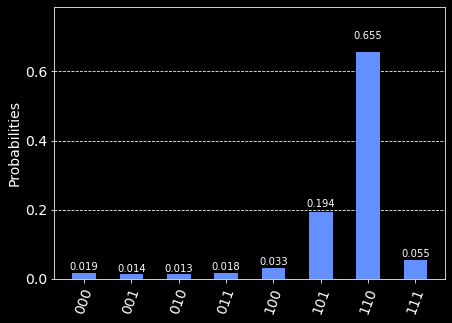

In [4]:
precision = 3
print('starting to create data for logical algorithm')
start = time.time()
createData_RxT1(1000,1/np.sqrt(2),precision,'logical')
print('ended in ' + str(time.time()-start) + ' seconds')

print('starting to create data for traditional algorithm')
start = time.time()
createData_RxT1(1000,1/np.sqrt(2),precision,'traditional')
print('ended in ' + str(time.time()-start) + ' seconds')

print('starting to create data for ideal algorithm')
start = time.time()
createData_RxT1(1000,1/np.sqrt(2),precision,'ideal')
print('ended in ' + str(time.time()-start) + ' seconds')

starting to create histogram for traditional algorithm
lost information is: 1.0436096431476443e-14


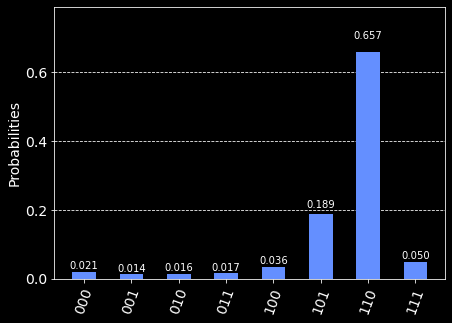

In [5]:
U = 'Rx'
precision = 3
print('starting to create histogram for logical algorithm')
d,li = createHistogram(1000,1/np.sqrt(2),precision,'logical',U=U,decay='T1')
print('lost information is: ' +str(li))
plt.style.use('dark_background')
plot_histogram(d)

starting to create histogram for ideal algorithm
lost information is: 3.3306690738754696e-16


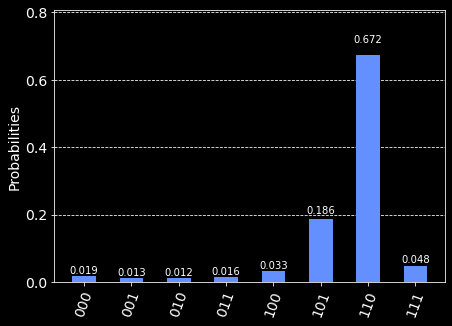

In [6]:
print('starting to create histogram for traditional algorithm')
d,li = createHistogram(1000,1/np.sqrt(2),precision,'traditional',U=U,decay='T1')
print('lost information is: ' +str(li))
plt.style.use('dark_background')
plot_histogram(d)

In [ ]:
print('starting to create histogram for ideal algorithm')
d,li = createHistogram(np.geomspace(10,1e3+100,20, endpoint=False)[11],1/np.sqrt(3),9,'ideal',U='Rx',decay='T1')
print('lost information is: ' +str(li))
plt.style.use('dark_background')

In [7]:
print(d)

'0.1001001111'

The binary representation of $\frac{1}{\sqrt{2}}$ to 10 binary digits is:

In [ ]:
num2bin(1/np.sqrt(2),10)

Which fits the results.

The next step is having one histogram and one lost information for each T2 and then
calculate the standard deviation of each of them, and deviding by the sqrt of the portion of successful runs.
First we create the data by running the next cell.

Data is created for 50 different T2 times in the range of $10^3,10^{7}$,
for an angle of $\frac{1}{\sqrt{3}}$, with precision of 9 digits and 10000 shots in the monta carlo experiment.

like any notebook, first create the conversion between T2 and worst case fidelity

In [17]:
T2_list = list(set([int(list(np.geomspace(1e3,1e7,50, endpoint=True))[i]) for i in range(50)]))
T2_list.sort()

plus = 1/np.sqrt(2)*(basis(2,0)+basis(2,1))
T1 = 1
f_worst_1q = []
f_worst_2q = []
start = time.time()
Tgate=1

for T2 in T2_list:

    qubit1 = InCoherentQuantumRegister(1,plus*plus.dag(), T1=1, T2 = T2, Tgate=1, dt = 1/20)
    qubit2 = InCoherentQuantumRegister(2,tensor([plus*plus.dag(),plus*plus.dag()]), T1=1, T2 = T2, Tgate=1, dt = 1/20)
    qubit1.setError(dephase = True, amplitude_damp=False)
    qubit2.setError(dephase = True, amplitude_damp=False)
    qubit2.run([[('i',None,None,1)]])
    qubit1.run([[('i',None,None,1)]])
    f_worst_1q.append(fidelity(plus*plus.dag(), qubit1.state))
    f_worst_2q.append(fidelity(tensor([plus*plus.dag(),plus*plus.dag()]), qubit2.state))


start = 0
end = 1000
plt.style.use('default')
x = np.log10(T2_list)
plt.xlabel('$log_{10}(T_2/T_{gate})$')
plt.plot(x[start:end], f_worst_1q[start:end], label = 'single qubit gate')
plt.plot(x[start:end], f_worst_2q[start:end], label = 'two qubit gate')
plt.style.use('default')
plt.ylabel('Worst Case Fidelity')
plt.title('starting from $10T_{gate}=T_2$')
plt.legend()
plt.show()

[2222996,
 2682695,
 3237457,
 3906939,
 4714866,
 5689866,
 6866488,
 8286427,
 10000000]

In [3]:
T2_list = list(np.geomspace(10,1e3+100,20, endpoint=False)) + list(np.geomspace(1e3,1e7,50, endpoint=True))

plus = 1/np.sqrt(2)*(basis(2,0)+basis(2,1))
T1 = 1
f_worst_1q = []
f_worst_2q = []
start = time.time()
Tgate=1

for T2 in T2_list:

    qubit1 = InCoherentQuantumRegister(1,fock_dm(2,1), T1=T2, T2 = 1, Tgate=1, dt = 1/20)
    qubit2 = InCoherentQuantumRegister(2,tensor([fock_dm(2,1),fock_dm(2,1)]), T1=T2, T2 = 1, Tgate=1, dt = 1/20)
    qubit1.setError(dephase = False, amplitude_damp=True)
    qubit2.setError(dephase = False, amplitude_damp=True)
    qubit2.run([[('i',None,None,1)]])
    qubit1.run([[('i',None,None,1)]])
    f_worst_1q.append(fidelity(fock_dm(2,1), qubit1.state))
    f_worst_2q.append(fidelity(tensor([fock_dm(2,1),fock_dm(2,1)]), qubit2.state))

In [5]:
def createAllData(nT2, angle, precision, U='Rz', decay='T2'):
    # creating data
    T2_list = list(np.geomspace(10,1e3+100,20, endpoint=False)) + list(np.geomspace(1e3,1e7,50, endpoint=True))
    start = time.time()
    if decay == 'T2':
        if U=='Rz':
            for T2 in T2_list:
                createData(T2,angle,precision,'traditional')
                createData(T2,angle,precision,'ideal')
                createData(T2,angle,precision,'logical')
                print('created data for T2/Tgate = ' + str(T2) + ' in ' + str(time.time()-start)+' seconds')
            print(' ----------------     created all data        --------------')
        else:
            for T2 in T2_list:
                createData_Rx(T2,angle,precision,'traditional')
                createData_Rx(T2,angle,precision,'logical')
                createData_Rx(T2,angle,precision,'ideal')
                print('created data for T2/Tgate = ' + str(T2) + ' in ' + str(time.time()-start)+' seconds')
            print(' ----------------     created all data        --------------')
    else:
        if U=='Rz':
            for T2 in T2_list:
                createData_RzT1(T2,angle,precision,'traditional')
                createData_RzT1(T2,angle,precision,'ideal')
                createData_RzT1(T2,angle,precision,'logical')
                print('created data for T2/Tgate = ' + str(T2) + ' in ' + str(time.time()-start)+' seconds')
            print(' ----------------     created all data        --------------')
        else:
            for T2 in T2_list:
                createData_RxT1(T2,angle,precision,'traditional')
                createData_RxT1(T2,angle,precision,'logical')
                createData_RxT1(T2,angle,precision,'ideal')
                print('created data for T2/Tgate = ' + str(T2) + ' in ' + str(time.time()-start)+' seconds')
            print(' ----------------     created all data        --------------')

def main(nT2, angle, precision,U='Rz', decay='T2'):
    # getting histograms:
    T2_list = list(np.geomspace(10,1e3+100,20, endpoint=False)) + list(np.geomspace(1e3,1e7,50, endpoint=True))
    STD_l = []
    STD_l_noLostInfo = []
    STD_t = []
    STD_t_noLostInfo = []
    STD_i = []
    STD_i_noLostInfo = []
    s = time.time()
    for T2 in T2_list:
        d_i,li_i = createHistogram(T2,angle,precision,'ideal',U=U, decay=decay)
        STD_i.append(getSTD(d_i,li_i)[0])
        STD_i_noLostInfo.append(getSTD(d_i,li_i)[1])

        d_l,li_l = createHistogram(T2,angle,precision,'logical',U=U, decay=decay)
        d_t,li_t = createHistogram(T2,angle,precision,'traditional',U=U, decay=decay)


        STD_l.append(getSTD(d_l,li_l)[0])
        STD_l_noLostInfo.append(getSTD(d_l,li_l)[1])
        STD_t.append(getSTD(d_t,li_t)[0])
        STD_t_noLostInfo.append(getSTD(d_t,li_t)[1])




        print('created STDs for T2/Tgate = ' + str(T2) + ' in ' + str(time.time()-s)+' seconds')
    print(' ----------------     created all data        --------------')

    # # save data
    # path = os.getcwd()
    # folder = os.path.join(path, 'data\\IPEA_Fisher\\'+U+'\\'+str(angle))
    # try:
    #     np.save(os.path.join(folder, 'logical_STDs'),STD_l)
    #     np.save(os.path.join(folder, 'logical_STDs_noLI'),STD_l_noLostInfo)
    #     np.save(os.path.join(folder, 'traditional_STDs'),STD_t)
    #     np.save(os.path.join(folder, 'traditional_STDs_noLI'),STD_t_noLostInfo)
    #     np.save(os.path.join(folder, 'ideal_STDs'),STD_i)
    #     np.save(os.path.join(folder, 'ideal_STDs_noLI'),STD_i_noLostInfo)
    # except:
    #     pass

    return STD_i,STD_t,STD_l,STD_i_noLostInfo,STD_t_noLostInfo,STD_l_noLostInfo

In [ ]:
precision = 9
nT2 = 50
T2 = np.geomspace(10,1e3+100,20, endpoint=False)[11]
createData_RxT1(T2,1/np.sqrt(3),precision,'ideal')




created data for T2/Tgate = 24420.5309454865 in 10373.658122777939 seconds
created data for T2/Tgate = 29470.517025518096 in 19546.01142525673 seconds
created data for T2/Tgate = 35564.80306223129 in 28803.504194021225 seconds
created data for T2/Tgate = 42919.34260128778 in 38115.05420279503 seconds
created data for T2/Tgate = 51794.74679231213 in 47169.78271365166 seconds
created data for T2/Tgate = 62505.51925273976 in 54376.81399059296 seconds
created data for T2/Tgate = 75431.20063354608 in 61677.66460633278 seconds
created data for T2/Tgate = 91029.81779915227 in 69186.68158221245 seconds
created data for T2/Tgate = 109854.11419875572 in 77969.739569664 seconds
created data for T2/Tgate = 132571.1365590108 in 85344.18929672241 seconds
created data for T2/Tgate = 159985.87196060573 in 92726.32714366913 seconds
created data for T2/Tgate = 193069.77288832495 in 101286.62355446815 seconds
created data for T2/Tgate = 232995.1810515372 in 110367.83334255219 seconds
created data for T2/

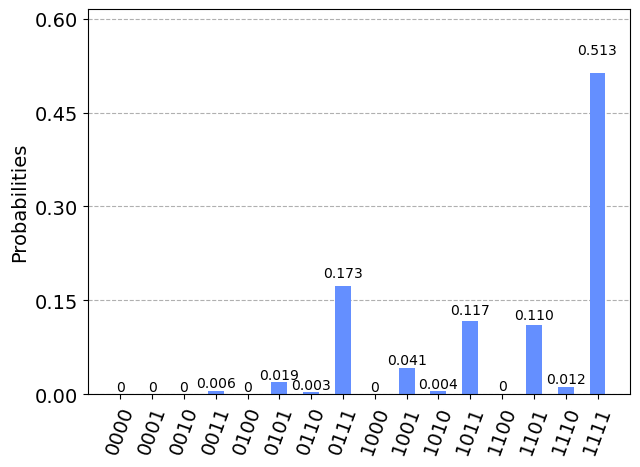

In [73]:
precision = 9
nT2 = 20
T2 = np.geomspace(10,1e3+100,20, endpoint=False)
print(T2)
createData_RxT1(T2,1/np.sqrt(3),precision,'logical')

# Now create the data:
## Here we create data for T1 and operator Rx, with good ancillas.

In [9]:
precision = 9
nT2 = 20
createAllData(nT2,1/np.sqrt(3),precision,U='Rz',decay='T1')

created data for T2/Tgate = 10.0 in 14404.371904850006 seconds
created data for T2/Tgate = 12.649391500428953 in 29169.067318677902 seconds
created data for T2/Tgate = 16.00071053311242 in 43666.993753671646 seconds
created data for T2/Tgate = 20.239925181837627 in 58023.69076919556 seconds
created data for T2/Tgate = 25.60227375644548 in 72556.61836624146 seconds
created data for T2/Tgate = 32.38531840464367 in 87222.01223421097 seconds
created data for T2/Tgate = 40.96545713663847 in 102571.84381270409 seconds
created data for T2/Tgate = 51.818810531538126 in 117736.66683125496 seconds
created data for T2/Tgate = 65.54764214999767 in 132263.64816498756 seconds
created data for T2/Tgate = 82.9137787485339 in 145094.32349538803 seconds
created data for T2/Tgate = 104.8808848170152 in 158503.80810785294 seconds
created data for T2/Tgate = 132.667937296182 in 170440.15586948395 seconds
created data for T2/Tgate = 167.8168678413764 in 181532.3764412403 seconds
created data for T2/Tgate = 

KeyboardInterrupt: 

In [32]:
d_l,li_l = createHistogram(1000.0,1/np.sqrt(3),4,'logical',U='Rz')
plot_histogram(d_l)

created STDs for T2/Tgate = 1000.0 in 0.05941414833068848 seconds
created STDs for T2/Tgate = 1206.792640639329 in 0.1153264045715332 seconds
created STDs for T2/Tgate = 1456.3484775012444 in 0.16203999519348145 seconds
created STDs for T2/Tgate = 1757.510624854791 in 0.2555122375488281 seconds
created STDs for T2/Tgate = 2120.9508879201903 in 0.30442047119140625 seconds
created STDs for T2/Tgate = 2559.547922699536 in 0.3478736877441406 seconds
created STDs for T2/Tgate = 3088.8435964774817 in 0.407268762588501 seconds
created STDs for T2/Tgate = 3727.593720314938 in 0.4561803340911865 seconds
created STDs for T2/Tgate = 4498.432668969444 in 0.5069146156311035 seconds
created STDs for T2/Tgate = 5428.67543932386 in 0.5479400157928467 seconds
created STDs for T2/Tgate = 6551.285568595509 in 0.5922460556030273 seconds
created STDs for T2/Tgate = 7906.043210907702 in 0.6385324001312256 seconds
created STDs for T2/Tgate = 9540.954763499944 in 0.7065095901489258 seconds
created STDs for T2

In [26]:
# save data
path = os.getcwd()
folder = os.path.join(path, 'data\\IPEA_Fisher\\'+'Rx\\T1'+'\\'+str(1/np.sqrt(3)))
try:
    STD_l = np.load(os.path.join(folder, 'logical_STDs.npy'))
    STD_l_noLI = np.load(os.path.join(folder, 'logical_STDs_noLI.npy'))
    STD_t = np.load(os.path.join(folder, 'traditional_STDs.npy'))
    STD_t_noLI = np.load(os.path.join(folder, 'traditional_STDs_noLI.npy'))
    STD_i = np.load(os.path.join(folder, 'ideal_STDs.npy'))
    STD_i_noLI = np.load(os.path.join(folder, 'ideal_STDs_noLI.npy'))
except:
    print('error')

array([[0.1233631 , 0.1222023 , 0.12132748, 0.12050889, 0.11981712,
        0.11932603, 0.11882411, 0.11848884, 0.11821154, 0.11798211,
        0.1176969 , 0.11753986, 0.11740985, 0.11730219, 0.11721304,
        0.1171392 , 0.11707804, 0.11702738, 0.11698541, 0.11695064,
        0.11692183, 0.11689797, 0.11687819, 0.11686181, 0.11684823,
        0.11683699, 0.11682767, 0.11681995, 0.11681355, 0.11671352,
        0.11670914, 0.1167055 , 0.11670248, 0.11669999, 0.11669792,
        0.1166962 , 0.11669478, 0.1166936 , 0.11669263, 0.11669182,
        0.11669115, 0.11669059, 0.11669013, 0.11668975, 0.11668944,
        0.11668917, 0.11668896, 0.11668878, 0.11668863, 0.11668851],
       [0.17885116, 0.17511349, 0.17199098, 0.16953102, 0.16752445,
        0.16581456, 0.16440159, 0.16332605, 0.16236618, 0.16157482,
        0.16092314, 0.16045568, 0.16001721, 0.15965027, 0.15934455,
        0.15909524, 0.15889369, 0.15870624, 0.15857894, 0.15846072,
        0.15835949, 0.15828378, 0.15820379, 0.1

In [34]:
T2_list

In [6]:
STD_i0,STD_t0,STD_l0,STD_i_noLI0,STD_t_noLI0,STD_l_noLI0 = [],[],[],[],[],[]
s = time.time()

In [7]:
for precision in [1,2,3,4,5,6,7,8,9]:

    STD_i_it,STD_t_it,STD_l_it,STD_i_noLI_it,STD_t_noLI_it,STD_l_noLI_it = main(20,1/np.sqrt(3),precision,U='Rz',decay='T1')
    STD_i0.append(STD_i_it)
    STD_t0.append(STD_t_it)
    STD_l0.append(STD_l_it)
    STD_i_noLI0.append(STD_i_noLI_it)
    STD_t_noLI0.append(STD_t_noLI_it)
    STD_l_noLI0.append(STD_l_noLI_it)
    print('----------------------------------------------------------'+str(time.time()-s)+'--------------------------------------------------------------')

created STDs for T2/Tgate = 10.0 in 0.05372285842895508 seconds
created STDs for T2/Tgate = 12.649391500428953 in 0.10190987586975098 seconds
created STDs for T2/Tgate = 16.00071053311242 in 0.14362335205078125 seconds
created STDs for T2/Tgate = 20.239925181837627 in 0.19921588897705078 seconds
created STDs for T2/Tgate = 25.60227375644548 in 0.2529158592224121 seconds
created STDs for T2/Tgate = 32.38531840464367 in 0.3242940902709961 seconds
created STDs for T2/Tgate = 40.96545713663847 in 0.3849527835845947 seconds
created STDs for T2/Tgate = 51.818810531538126 in 0.4278125762939453 seconds
created STDs for T2/Tgate = 65.54764214999767 in 0.4669830799102783 seconds
created STDs for T2/Tgate = 82.9137787485339 in 0.5081863403320312 seconds
created STDs for T2/Tgate = 104.8808848170152 in 0.5447549819946289 seconds
created STDs for T2/Tgate = 132.667937296182 in 0.5856771469116211 seconds
created STDs for T2/Tgate = 167.8168678413764 in 0.6244957447052002 seconds
created STDs for T2/

In [ ]:
print(STD_l0)

In [ ]:
STD_l = np.concatenate((STD_l0,STD_l), axis = 1)
STD_i = np.concatenate((STD_i0,STD_i), axis = 1)
STD_t = np.concatenate((STD_t0,STD_t), axis = 1)
STD_l_noLI = np.concatenate((STD_l_noLI0,STD_l_noLI), axis = 1)
STD_i_noLI = np.concatenate((STD_i_noLI0,STD_i_noLI), axis = 1)
STD_t_noLI = np.concatenate((STD_t_noLI0,STD_t_noLI), axis = 1)

In [8]:
from scipy.io import savemat
savemat('IPEASTDsT1_Rz_all.mat', dict(f_worst_1q=f_worst_1q,f_worst_2q = f_worst_2q, T2_list=T2_list, logical_STDs=STD_l0,logical_STDs_noLI=STD_l_noLI0, traditional_STDs=STD_t0, traditional_STDs_noLI=STD_t_noLI0, ideal_STDs=STD_i0, ideal_STDs_noLI=STD_i_noLI0))

In [9]:
# save data
path = os.getcwd()
folder = os.path.join(path, 'data\\IPEA_Fisher\\'+'Rz\\T1\\'+str(1/np.sqrt(3)))
try:
    np.save(os.path.join(folder, 'logical_STDs'),STD_l0)
    np.save(os.path.join(folder, 'logical_STDs_noLI'),STD_l_noLI0)
    np.save(os.path.join(folder, 'traditional_STDs'),STD_t0)
    np.save(os.path.join(folder, 'traditional_STDs_noLI'),STD_t_noLI0)
    np.save(os.path.join(folder, 'ideal_STDs'),STD_i0)
    np.save(os.path.join(folder, 'ideal_STDs_noLI'),STD_i_noLI0)
except:
    pass




# Plot it


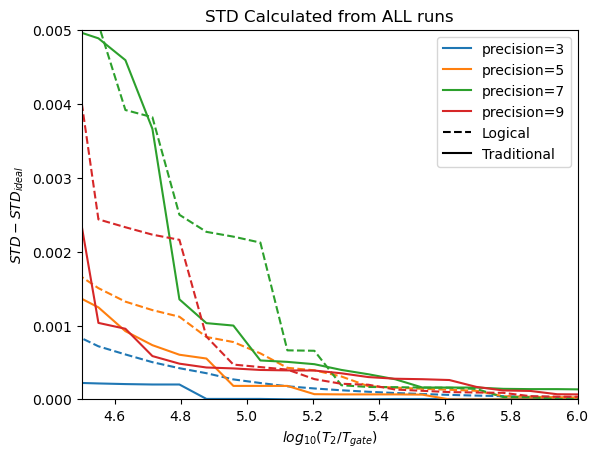

In [21]:
ax = plt.gca()
for i in [0,2,4,6]:
    color = next(ax._get_lines.prop_cycler)['color']
    s = 0
    e = 50
    # f = f_worst_2q
    f = np.log10(np.geomspace(1e3,1e7,50, endpoint=True))
    plt.style.use('default')
    plt.ylabel('$STD-STD_{ideal}$')
    plt.xlabel('$log_{10}(T_2/T_{gate})$')
    plt.title('STD Calculated from ALL runs')
    # if f == f_worst_1q:
    #     plt.xlabel('Worst-Case Single Qubit Gate Fidelity')
    # else:
    #     plt.xlabel('Worst-Case Entangling Gate Fidelity')
    # plt.plot(f[s:e],STD_i[s:e], label='ideal')
    plt.plot(f[s:e],np.array(STD_l[i][s:e])-np.array(STD_i[i][s:e]),'--',color= color)
    plt.plot(f[s:e],np.array(STD_t[i][s:e])-np.array(STD_i[i][s:e]),color= color, label='precision='+str(i+3))
    # plt.plot(f[s:e],np.array(STD_t[i][s:e])-np.array(STD_l[i][s:e]),color= color, label='precision='+str(i+3))
plt.ylim((0,0.005))
plt.xlim((4.5,6))
# plt.plot(np.NaN, np.NaN,':', color='black', label='Single')
plt.plot(np.NaN, np.NaN,'--', color='black', label='Logical')
plt.plot(np.NaN, np.NaN, color='black', label='Traditional')
plt.legend()
plt.show()

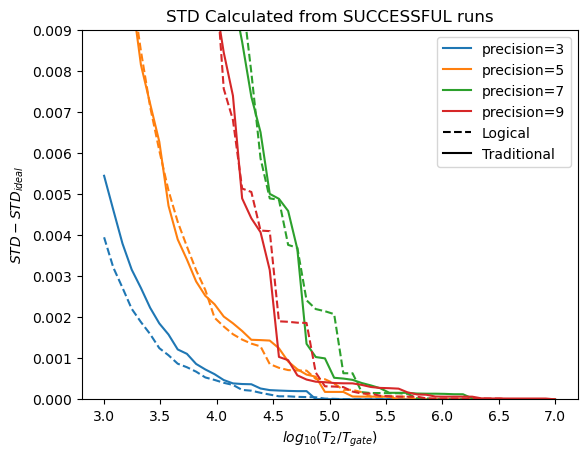

In [26]:
ax = plt.gca()
for i in [0,2,4,6]:
    color = next(ax._get_lines.prop_cycler)['color']
    s = 0
    e = 50
    # f = f_worst_2q
    f = np.log10(np.geomspace(1e3,1e7,50, endpoint=True))
    plt.style.use('default')
    plt.ylabel('$STD-STD_{ideal}$')
    plt.xlabel('$log_{10}(T_2/T_{gate})$')
    plt.title('STD Calculated from SUCCESSFUL runs')
    # if f == f_worst_1q:
    #     plt.xlabel('Worst-Case Single Qubit Gate Fidelity')
    # else:
    #     plt.xlabel('Worst-Case Entangling Gate Fidelity')
    # plt.plot(f[s:e],STD_i[s:e], label='ideal')
    plt.plot(f[s:e],np.array(STD_l_noLI[i][s:e])-np.array(STD_i_noLI[i][s:e]),'--',color= color)
    plt.plot(f[s:e],np.array(STD_t_noLI[i][s:e])-np.array(STD_i_noLI[i][s:e]),color= color, label='precision='+str(i+3))
# plt.plot(np.NaN, np.NaN,':', color='black', label='Single')
# plt.xlim((4.75,5))
plt.ylim((0,0.009))
plt.plot(np.NaN, np.NaN,'--', color='black', label='Logical')
plt.plot(np.NaN, np.NaN, color='black', label='Traditional')
plt.legend()
plt.show()



Now we create the same data, but for the operator Rx and angle $\frac{1}{\sqrt{2}}$


In [15]:
precision = 5
print('starting to create data for logical algorithm')
start = time.time()
createData_Rx(100,1/np.sqrt(2),precision,'logical')
print('ended in ' + str(time.time()-start) + ' seconds')

print('starting to create data for traditional algorithm')
start = time.time()
createData_Rx(100,1/np.sqrt(2),precision,'traditional')
print('ended in ' + str(time.time()-start) + ' seconds')

print('starting to create data for ideal algorithm')
start = time.time()
createData_Rx(100,1/np.sqrt(2),precision,'ideal')
print('ended in ' + str(time.time()-start) + ' seconds')

starting to create data for logical algorithm
ended in 303.6038591861725 seconds
starting to create data for traditional algorithm
ended in 11.62122917175293 seconds
starting to create data for ideal algorithm
ended in 1.1406428813934326 seconds


starting to create histogram for logical algorithm
lost information is: 0.9786382196732514


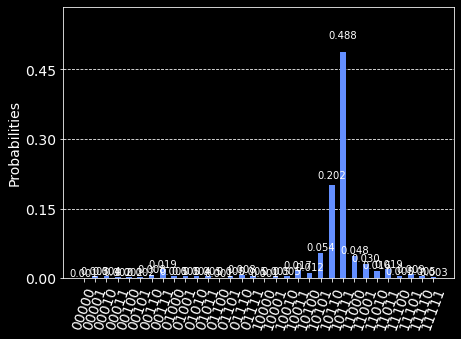

In [17]:
print('starting to create histogram for logical algorithm')
d,li = createHistogram(100,1/np.sqrt(2),precision,'logical',1000)
print('lost information is: ' +str(li))
plt.style.use('dark_background')
plot_histogram(d)

starting to create histogram for traditional algorithm
lost information is: 7.378117716594449e-11


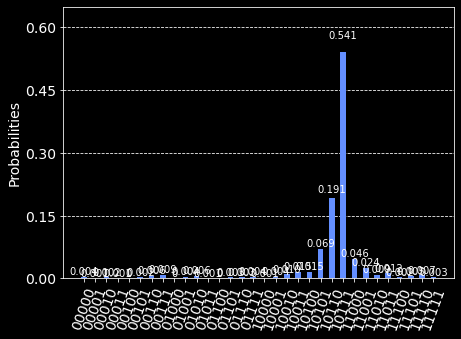

In [18]:
print('starting to create histogram for traditional algorithm')
d,li = createHistogram(100,1/np.sqrt(2),precision,'traditional',1000)
print('lost information is: ' +str(li))
plt.style.use('dark_background')
plot_histogram(d)

starting to create histogram for ideal algorithm
lost information is: 1.1517453657461373e-15


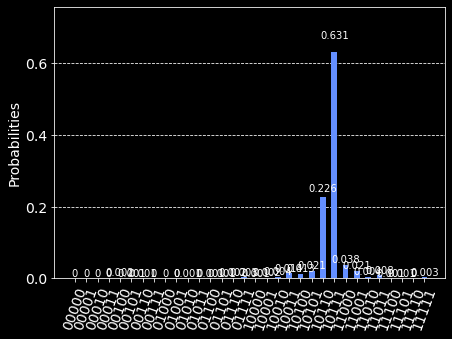

In [19]:
print('starting to create histogram for ideal algorithm')
d,li = createHistogram(100,1/np.sqrt(2),precision,'ideal',1000)
print('lost information is: ' +str(li))
plt.style.use('dark_background')
plot_histogram(d)


In [251]:
def IPEA_for_simpleRegisterd(angle, k, omega_k, noisy=False, reg_params = None, U = 'Rz'):
    """
    this function runs a single iteration of traditional IPEA.
    :param angle: the angle of the measured operator, with phi = 2pi*(angle) and 0<=angle<1
    :param k: int, the iteration, starting from m (number of desired digits) and ending in 1
    :param omega_k: the parameter as to which the phase kickback happens.
    :param noisy: True for noisy register, with only T2 noise
    :param reg_params: (T1,T2,T1s,T2s,dt,Tgate) as defined for the simulators (documentation there).
    :return: state of register right before the measurement.
    """

    if U=='Rz':
        initial = initial_state_for_NoisyRegister
        Entangling_gate = 'CNOT'
    elif U=='Rx':
        initial = initial_state_for_NoisyRegister_plus
        Entangling_gate = 'CZ'
    if noisy:
        (T1,T2,T1s,T2s,dt,Tgate) = reg_params
        register = InCoherentQuantumRegister(2,initial,T1,T2,T1s=T1s,T2s=T2s,dt=dt,Tgate=Tgate)
        register.setError(dephase=True,amplitude_damp=False)
    else:
        (T1,T2,T1s,T2s,dt,Tgate) = reg_params
        register = InCoherentQuantumRegister(2,initial,T1,T2,T1s=T1s,T2s=T2s,dt=dt,Tgate=Tgate)
        register.setError(dephase=False,amplitude_damp=False)

    command = [[('H',0,None,None)]]
    register.run(command)

    for i in range(2**(k-1)):
        command = [[(U,1,None,2*np.pi*angle/4)]]
        register.run(command)

    command = [[(Entangling_gate,1,0,None)]]
    digit = register.run(command)

    for i in range(2**(k-1)):
        command = [[(U,1,None,-2*np.pi*angle/4)]]
        register.run(command)
        register.run(command)

    command = [[(Entangling_gate,1,0,None)]]
    register.run(command)

    for i in range(2**(k-1)):
        command = [[(U,1,None,2*np.pi*angle/4)]]
        register.run(command)

    command = [[('Rz',0,None,omega_k)]]
    register.run(command)

    command = [[('H',0,None,None)]]
    register.run(command)

    return register.state

def IPEA_for_logicalRegisterd(angle, k, omega_k, noisy=False, reg_params = None, U = 'Rz'):
    """
    this function runs a single iteration of traditional IPEA.
    :param angle: the angle of the measured operator, with phi = 2pi*(angle) and 0<=angle<1
    :param k: int, the iteration, starting from m (number of desired digits) and ending in 1
    :param omega_k: the parameter as to which the phase kickback happens.
    :param noisy: True for noisy register, with only T2 noise
    :param reg_params: (T1,T2,T1s,T2s,dt,Tgate) as defined for the simulators (documentation there).
    :return: state of register right before the measurement.
    """
    if U=='Rz':
        initial = initial_state_for_NoisyLogicalRegister
        Entangling_gate = 'CNOT'
    elif U=='Rx':
        initial = initial_state_for_NoisyLogicalRegister_plus
        Entangling_gate = 'CZ'
    if noisy:
        (T1,T2,T1s,T2s,dt,Tgate) = reg_params
        register = InCoherentQuantumRegister(6,initial,T1,T2,T1s=T1s,T2s=T2s,dt=dt,Tgate=Tgate)
        register.setError(dephase=True,amplitude_damp=False)
    else:
        (T1,T2,T1s,T2s,dt,Tgate) = reg_params
        register = InCoherentQuantumRegister(6,initial,T1,T2,T1s=T1s,T2s=T2s,dt=dt,Tgate=Tgate)
        register.setError(dephase=False,amplitude_damp=False)

    prepare_for_LogicalRegister(register,True)

    H_for_LogicalRegister(register, True)

    # first sensor rotation
    for i in range(2**(k-1)):
        command = [[(U,5,None,2*np.pi*angle/4)]]
        register.run(command)
        # register.run([[('SingleQubitOperator',5,None,(-1j*2*np.pi*angle/8*sigmaz()).expm())]])

    # controlled not
    register.run([[(Entangling_gate, 5, 0, None),(Entangling_gate, 5, 1, None),(Entangling_gate, 5, 2, None),(Entangling_gate, 5, 3, None),(Entangling_gate, 5, 4, None)]])

    # second rotation
    for i in range(2**(k-1)):
        command = [[(U,5,None,-2*np.pi*angle/4)]]
        register.run(command)
        register.run(command)
        # register.run([[('SingleQubitOperator',5,None,(1j*2*np.pi*angle/8*sigmaz()).expm())]])
        # register.run([[('SingleQubitOperator',5,None,(1j*2*np.pi*angle/8*sigmaz()).expm())]])

    # controlled not
    register.run([[(Entangling_gate, 5, 0, None),(Entangling_gate, 5, 1, None),(Entangling_gate, 5, 2, None),(Entangling_gate, 5, 3, None),(Entangling_gate, 5, 4, None)]])

    # third and last
    for i in range(2**(k-1)):
        command = [[(U,5,None,2*np.pi*angle/4)]]
        register.run(command)
        # register.run([[('SingleQubitOperator',5,None,(-1j*2*np.pi*angle/8*sigmaz()).expm())]])

    rotation_for_LogicalRegister(register,omega_k)

    H_for_LogicalRegister(register, True)

    # return register.state

    EC_for_LogicalRegister(register, True, LPS=True, U=U)

    return register.state

In [252]:
angle = 1/np.sqrt(2)
k = 5
omega_k = 0.25
noisy=True
reg_params_s = (1,1,[1,1],[1e10,1e10],1/20,1)
reg_params_l = (1,1,[1,1,1,1,1,1],[1e10,1e10,1e10,1e10,1e10,1e10],1/20,1)
state_t = IPEA_for_simpleRegisterd(angle, k, omega_k, noisy=True, reg_params = reg_params_s)
state_l = IPEA_for_logicalRegisterd(angle, k, omega_k, noisy=True, reg_params = reg_params_l)

In [253]:
state_t

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 3.35496421e-01+0.00000000e+00j
  0.00000000e+00-4.60032935e-12j 1.80355574e-11-4.72163709e-01j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+4.60034654e-12j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 1.81285481e-11+4.72163709e-01j
  0.00000000e+00+0.00000000e+00j 6.64503579e-01+0.00000000e+00j]]

In [254]:
debugLogical(state_l)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.        +0.j        0.33549641+0.j        0.        +0.j
  0.        -0.4721637j]
 [0.        +0.j        0.        +0.j        0.        +0.j
  0.        +0.j       ]
 [0.        +0.j        0.        +0.4721637j 0.        +0.j
  0.66450356+0.j       ]]

In [255]:
state_i = IPEA_for_simpleRegisterd(angle, k, omega_k, noisy=False, reg_params = reg_params_l)
state_i

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.33549642+0.j         0.        +0.j
  0.        -0.47216371j]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.47216371j 0.        +0.j
  0.66450358+0.j        ]]